## Perturbation of sequences
### Dataset: SARS-CoV-2 sequences of S Protein sequences of Humans only
### Number of sequences = 1311
### Model: Transformer

In [7]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path.append(os.path.join(os.getcwd(), ".."))
sys.path

['/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sarscov2',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python310.zip',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/lib-dynload',
 '',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages',
 '/home/grads/blessyantony/anaconda3/envs/zoonosis/lib/python3.10/site-packages/PyQt5_sip-12.11.0-py3.10-linux-x86_64.egg',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sarscov2/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sarscov2/../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sarscov2/..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sarscov2/../../..',
 '/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sarscov2/../..

In [8]:
from models.nlp.transformer import transformer, transformer_model
from datasets.protein_sequence_dataset import ProteinSequenceDataset
from utils import utils, nn_utils, visualization_utils
from models.nlp.embedding.padding import Padding
from torch.utils.data import DataLoader
from training.fine_tuning import host_prediction

import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import re

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from Bio import SeqIO
from Bio.Seq import Seq
from Bio import motifs


In [20]:
input_file_path = "/home/grads/blessyantony/dev/git/zoonosis/input/data/coronaviridae/sarscov2/sarscov2-S-WIV04ref.csv"
pertubred_output_file_path = "/home/grads/blessyantony/dev/git/zoonosis/output/raw/coronaviridae/20231204/perturbed_dataset_prediction/sarscov2-S-WIV04/transfer_learning_mlm_fnn_2l_lr1e-5/processed/tl_tf_wiv04_s_prot.csv_WIV04.csv"


uniprotkb_sarscov2_human_df = pd.read_csv(input_file_path)

label_groupings = {
                    "Pig": [ "Sus scrofa (Pig) [TaxID: 9823]" ],
                    "Human": [ "Homo sapiens (Human) [TaxID: 9606]" ],
                    "Wild turkey": [ "Meleagris gallopavo (Wild turkey) [TaxID: 9103]" ],
                    "Japanese pipistrelle": [ "Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]" ],
                    "Lesser bamboo bat": [ "Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]" ],
                    "Chicken": [ "Gallus gallus (Chicken) [TaxID: 9031]" ],
                    "Bovine": [ "Bos taurus (Bovine) [TaxID: 9913]" ]
                }

amino_acid_idx_map = {'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
                  'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
                  'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
                  'O': 16, 'S': 17, 'U': 18, 'T': 19, 'W': 20,
                  'Y': 21, 'V': 22, 'B': 23, 'Z': 24, 'X': 25,
                  'J': 26}

idx_amino_acid_map = {v:k for k,v in amino_acid_idx_map.items()}
id_col = "id"
test_sequence_settings =  {
    "sequence_col": "seq",
    "batch_size": 1,
    "max_sequence_length": 1366,
    "pad_sequence_val": 0,
    "truncate": True,
    "feature_type": "token"
}


label_settings = {
    "label_col": "virus_host",
    "exclude_labels": [ "nan"],
    "label_groupings":  label_groupings
}

model = {
    "max_seq_len": 1366,
    "model_path": "/home/grads/blessyantony/dev/git/zoonosis/output/raw/coronaviridae/20231127/fine_tuning/host_prediction/host_prediction_fnn_2l_lr1e-5_itr0.pth",
    "depth": 2,
    "n_classes": 7,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024,
}


pre_train_encoder_settings = {
    "model_name": "transformer_encoder-l_6-h_8-lr1e-4-mlm",
    "n_heads": 8,
    "depth": 6,
    "input_dim": 512, # input embedding dimension
    "hidden_dim": 1024,
    "n_tokens": 28,
    "max_seq_len": 1366
}

def post_plot_config():
    plt.rcParams['figure.autolayout'] = True
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 8

In [10]:
uniprotkb_sarscov2_human_df

,id,seq,virus,seq_len,virus_host,binary_label
0,WIV04,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...,WIV04(MN996528.1) Wuhan variant index virus,1273,Homo sapiens (Human) [TaxID: 9606],Human


In [15]:
def get_token_dataset_loader(df, sequence_settings, label_settings):
    label_col = label_settings["label_col"]
    
    seq_col = sequence_settings["sequence_col"]
    batch_size = sequence_settings["batch_size"]
    max_seq_len = sequence_settings["max_sequence_length"]
    pad_sequence_val = sequence_settings["pad_sequence_val"]
    truncate = sequence_settings["truncate"]
    
    df = df[[seq_col, label_col]]
    df, index_label_map = utils.transform_labels(df, label_settings, classification_type="multi")

    dataset = ProteinSequenceDataset(df, seq_col, max_seq_len, truncate, label_col)
    return index_label_map, DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True,
                      collate_fn=Padding(max_seq_len, pad_sequence_val))


def get_dataset_loader_for_seq(uniprot_id):
    id_df = uniprotkb_sarscov2_human_df[uniprotkb_sarscov2_human_df["id"] == uniprot_id]
    index_label_map, dataset_loader =  get_token_dataset_loader(id_df, test_sequence_settings, label_settings)
    return id_df, index_label_map, dataset_loader

### Load the model

In [16]:
pre_trained_encoder_model = transformer.get_transformer_encoder(pre_train_encoder_settings)
# Set the pre_trained model within the task config
model["pre_trained_model"] = pre_trained_encoder_model
prediction_model = host_prediction.get_host_prediction_model(model)

prediction_model.load_state_dict(torch.load(model["model_path"], map_location=nn_utils.get_device()))
prediction_model.eval()
prediction_model.zero_grad()

TransformerEncoder(
  (embedding): EmbeddingLayer(
    (token_embedding): Embedding(28, 512)
    (positional_embedding): PositionalEncoding()
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-5): 6 x EncoderLayer(
        (self_attn): MultiHeadAttention(
          (W_Q): Linear(in_features=512, out_features=512, bias=True)
          (W_K): Linear(in_features=512, out_features=512, bias=True)
          (W_V): Linear(in_features=512, out_features=512, bias=True)
          (W_O): Linear(in_features=512, out_features=512, bias=True)
        )
        (feed_forward): FeedForwardLayer(
          (W_1): Linear(in_features=512, out_features=1024, bias=True)
          (W_2): Linear(in_features=1024, out_features=512, bias=True)
        )
        (residual_connections): ModuleList(
          (0-1): 2 x ResidualConnectionLayer(
            (norm): NormalizationLayer()
          )
        )
      )
    )
    (norm): NormalizationLayer()
  )
)
Number of parameters =  12618752
HostPredict

In [17]:
def validate(model, dataset_loader, index_label_map):
    with torch.no_grad():
        model.eval()

        results = []

        for _, data in enumerate(dataset_loader):
            # get input and labels; data is a list of [(inputs, labels)]
            inputs, labels = data

            output = model(inputs)

            # to get probabilities of the output
            output = F.softmax(output, dim=-1)
            result_df = pd.DataFrame(output.cpu().numpy())
            result_df.rename(columns=index_label_map, inplace=True)
            result_df["y_true"] = labels.cpu().numpy()
            result_df["y_true"] = result_df["y_true"].map(index_label_map)
            
            results.append(result_df)
    
    return inputs, pd.concat(results, ignore_index=True)

In [21]:
index_label_map, dataset_loader = get_token_dataset_loader(uniprotkb_sarscov2_human_df, test_sequence_settings, label_settings)

inputs, output_df = validate(prediction_model, dataset_loader, index_label_map)
perturbed_output_df = pd.read_csv(pertubred_output_file_path)

orig_seq_human_pred = output_df["Human"].values[0]
print(f"Prediction for human class for original sequence: {orig_seq_human_pred}")
perturbed_output_df = perturbed_output_df[["Human", "id", "orig_token", "perturb_pos", "new_token"]]
perturbed_output_df["pred_diff"] = perturbed_output_df["Human"] - orig_seq_human_pred
pivot_df = perturbed_output_df.pivot(columns="perturb_pos", index="new_token", values="pred_diff")

Grouping labels using config : {'Pig': ['Sus scrofa (Pig) [TaxID: 9823]'], 'Human': ['Homo sapiens (Human) [TaxID: 9606]'], 'Wild turkey': ['Meleagris gallopavo (Wild turkey) [TaxID: 9103]'], 'Japanese pipistrelle': ['Pipistrellus abramus (Japanese pipistrelle) (Pipistrellus javanicus abramus) [TaxID: 105295]'], 'Lesser bamboo bat': ['Tylonycteris pachypus (Lesser bamboo bat) (Vespertilio pachypus) [TaxID: 258959]'], 'Chicken': ['Gallus gallus (Chicken) [TaxID: 9031]'], 'Bovine': ['Bos taurus (Bovine) [TaxID: 9913]']}
label_idx_map={'Bovine': 0, 'Chicken': 1, 'Human': 2, 'Japanese pipistrelle': 3, 'Lesser bamboo bat': 4, 'Pig': 5, 'Wild turkey': 6}
idx_label_map={0: 'Bovine', 1: 'Chicken', 2: 'Human', 3: 'Japanese pipistrelle', 4: 'Lesser bamboo bat', 5: 'Pig', 6: 'Wild turkey'}
Prediction for human class for original sequence: 0.9851977229118347


/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sarscov2/../../../utils/utils.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df[label_col].isin(v), label_col] = k
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sarscov2/../../../utils/utils.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[label_col] = df[label_col].transform(lambda x: label_idx_map[x])
/home/grads/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/perturbation/sarscov2/../../../datasets/protein_sequence_dataset.py:29: 

In [22]:
n_bins = 12
n = perturbed_output_df.shape[0]
freq, bins = np.histogram(perturbed_output_df["pred_diff"], bins=n_bins)
hist_map = []
for i in range(n_bins):
    hist_map.append({"start": bins[i], "end":bins[i+1], "count": freq[i], "percentage": freq[i]/n*100})

    
hist_df = pd.DataFrame(hist_map)
hist_df.head(20)

,start,end,count,percentage
0,-0.087193,-0.079488,1,0.003142
1,-0.079488,-0.071782,0,0.000000
2,-0.071782,-0.064077,0,0.000000
3,-0.064077,-0.056372,0,0.000000
4,-0.056372,-0.048667,0,0.000000
5,-0.048667,-0.040962,0,0.000000
6,-0.040962,-0.033257,0,0.000000
7,-0.033257,-0.025552,0,0.000000
8,-0.025552,-0.017847,0,0.000000
9,-0.017847,-0.010141,45,0.141394


In [36]:
df = perturbed_output_df.pivot(columns="perturb_pos", index="new_token", values="pred_diff")
df

perturb_pos,0,1,2,3,4,5,6,7,8,9,...,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272
new_token,,,,,,,,,,,,,,,,,,,,,
A,-1.376573e-03,-0.000219,0.000125,-0.000233,-0.000139,0.000049,-0.000073,-0.000071,-0.000187,-0.000122,...,-1.216291e-05,-0.000092,0.000165,0.000024,-0.000019,0.000119,-0.000028,-0.000005,0.000007,0.000010
B,-1.410483e-03,-0.000290,0.000061,-0.000275,-0.000109,0.000105,-0.000029,-0.000023,-0.000164,-0.000046,...,-3.946291e-05,-0.000112,0.000141,-0.000006,-0.000055,0.000085,-0.000057,-0.000031,-0.000016,-0.000013
C,-1.695993e-03,-0.000370,0.000135,-0.000267,-0.000086,0.000129,-0.000018,-0.000029,-0.000184,-0.000103,...,4.457709e-05,-0.000012,0.000236,0.000097,0.000024,0.000172,0.000024,0.000034,0.000042,0.000077
D,-1.384823e-03,-0.000332,-0.000065,-0.000378,-0.000211,0.000020,-0.000091,-0.000087,-0.000210,-0.000243,...,-2.631529e-04,-0.000275,-0.000061,-0.000187,-0.000197,-0.000041,-0.000184,-0.000189,-0.000176,-0.000198
E,-1.212823e-03,-0.000308,-0.000077,-0.000434,-0.000245,0.000020,-0.000114,-0.000096,-0.000238,-0.000212,...,-1.693229e-04,-0.000297,-0.000083,-0.000215,-0.000186,-0.000016,-0.000155,-0.000153,-0.000183,-0.000235
F,-1.452263e-03,NaN,0.000800,NaN,0.000233,0.000719,0.000260,0.000288,0.000602,0.000217,...,7.877088e-06,-0.000029,0.000249,0.000095,0.000007,0.000129,-0.000011,0.000017,0.000049,0.000095
G,-1.421573e-03,-0.000252,0.000006,-0.000280,-0.000153,0.000062,-0.000074,-0.000086,-0.000198,-0.000133,...,-1.952291e-05,-0.000104,0.000147,NaN,-0.000040,0.000096,-0.000033,-0.000022,0.000015,-0.000004
H,-1.273873e-03,-0.000072,0.000343,0.000077,0.000214,0.000428,0.000310,0.000383,0.000195,0.000837,...,1.472709e-05,-0.000058,0.000191,0.000036,0.000018,0.000127,-0.000011,NaN,0.000023,0.000025
I,-1.567323e-03,-0.000378,-0.000024,-0.000368,-0.000227,-0.000018,-0.000150,-0.000162,-0.000363,-0.000221,...,-1.156291e-05,-0.000069,0.000204,0.000056,-0.000014,0.000116,-0.000031,-0.000001,0.000029,0.000052


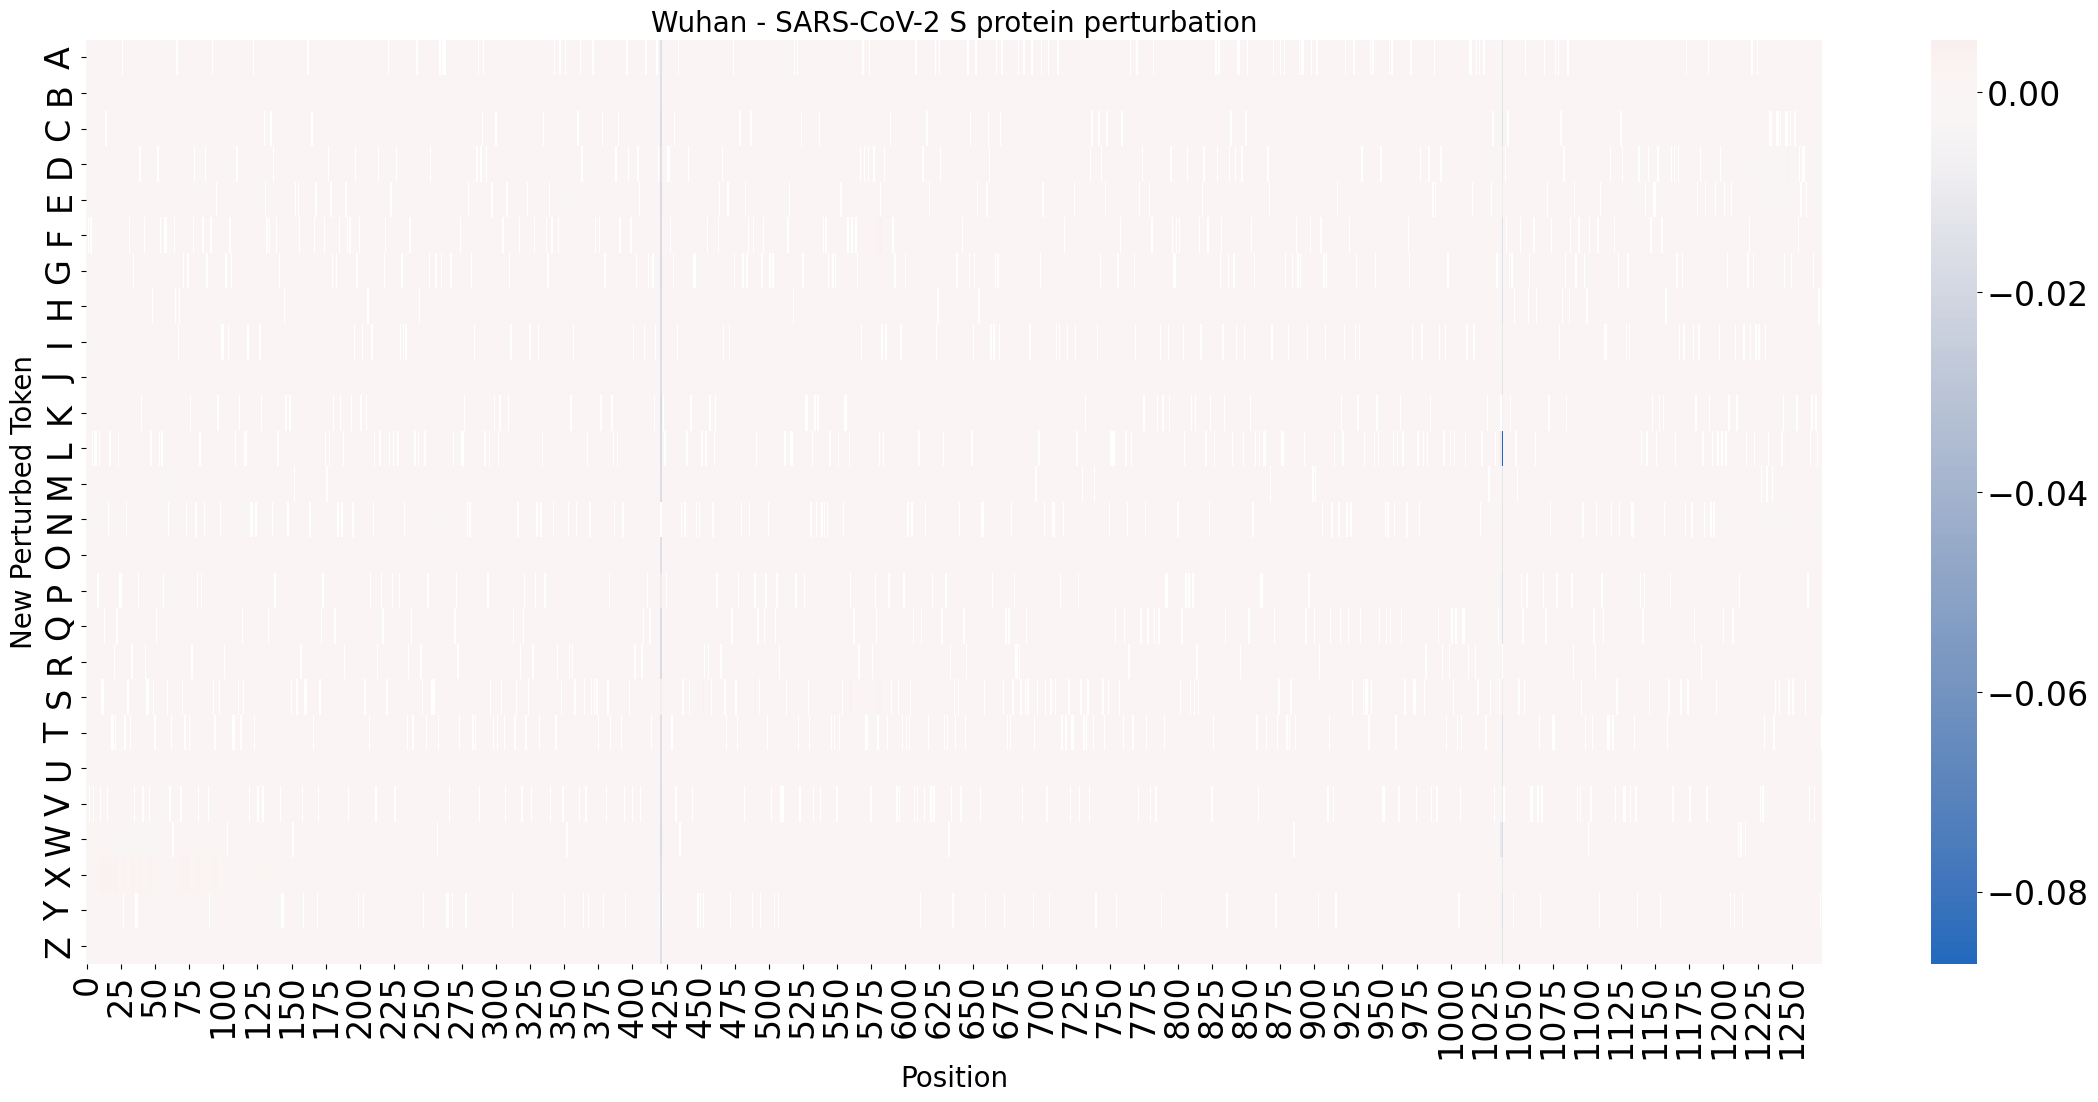

In [31]:
plt.figure(figsize=(28,12))
cmap = sns.color_palette("vlag", as_cmap=True)
ax = sns.heatmap(pivot_df, cmap=cmap, center=0)
ax.set_title("Wuhan - SARS-CoV-2 S protein perturbation", fontsize=20)
ax.set_ylabel("New Perturbed Token", fontsize=20)
ax.set_xlabel("Position", fontsize=20)
plt.show()

In [27]:
pivot_df.mean(axis=0).nsmallest(10)

perturb_pos
1038   -0.015793
421    -0.015547
1037   -0.003005
0      -0.001370
64     -0.001036
1039   -0.001018
54     -0.000615
63     -0.000555
58     -0.000549
57     -0.000489
dtype: float64